# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50

SEED = 12345

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=SEED) 

Found 7591 validated image filenames.


In [3]:
CSV_PATH = '/datasets/faces/labels.csv'
IMG_PATH = '/datasets/faces/final_files/'

In [4]:
features, target = next(train_gen_flow)

In [5]:
df = pd.read_csv(CSV_PATH)

In [6]:
df.sample(10)

,file_name,real_age
6117,006120.jpg,45
6645,006650.jpg,30
1218,001218.jpg,30
1913,001913.jpg,24
5108,005108.jpg,32
7364,007386.jpg,50
5167,005167.jpg,38
3586,003586.jpg,70
5397,005397.jpg,19
3821,003821.jpg,58


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [9]:
len(df[df['file_name'].duplicated()])

0

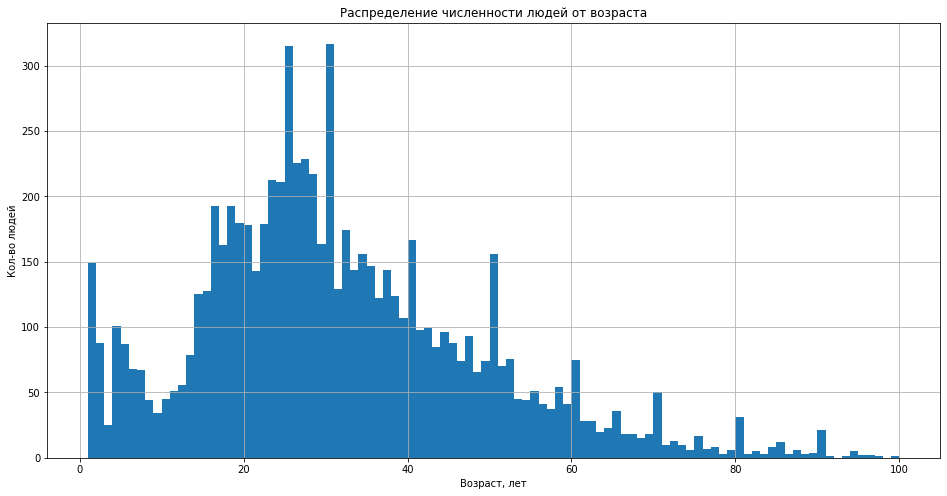

In [10]:
df['real_age'].plot(kind='hist', bins=99, figsize=(16, 8), grid=True)
plt.title('Распределение численности людей от возраста')
plt.ylabel('Кол-во людей')
plt.xlabel('Возраст, лет');

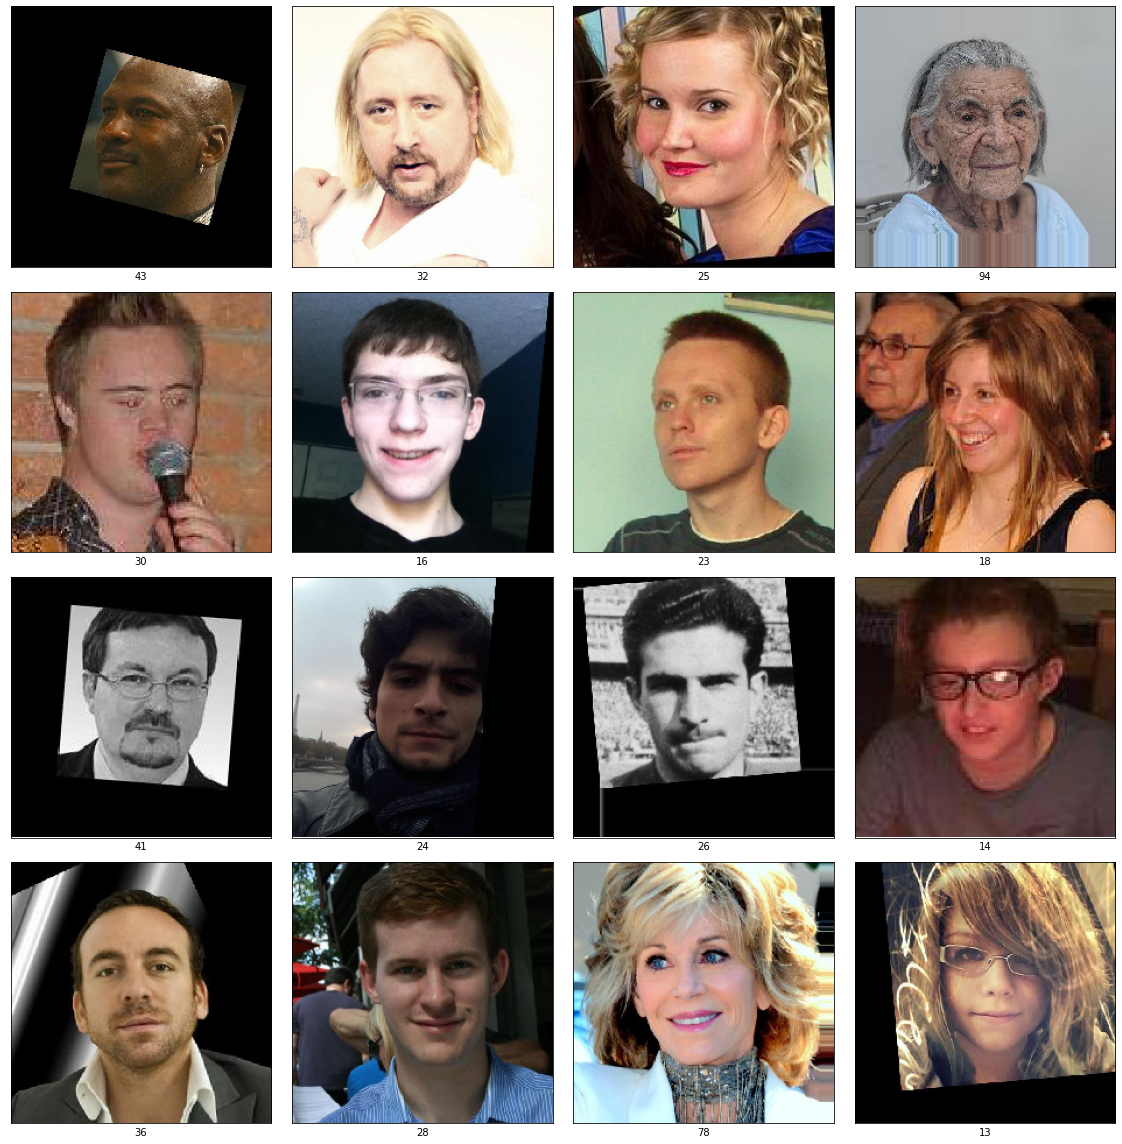

In [11]:
fig = plt.figure(figsize=(16, 16))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i+16])
    plt.xlabel(target[i+16])
    
    # для компактности оси остаются пустыми и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

#### Вывод:
Датасет содержит более 7500 фотографий без пропусков и дубликатов. В нем присутствуют как цветные, так и черно-белые изображения с разными ракурсами и различными артефактами, такими как закрытые лица, тени, предметы на фоне и другие факторы.

Распределение возрастных групп в датасете неоднородно, с наибольшим количеством фотографий людей в возрасте 15-30 лет. Отмечаются пики в возрасте 25 и 30 лет, а также значительное количество фотографий младенцев возрастом 1 год и младше. Возможно, это связано с округлением возраста детей до 1 года. Группа возраста 0 лет отсутствует.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < 
def load_train(path):
    # создание загрузчика данных
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255, vertical_flip=True)
    
    # загрузка данных (по частям/батчам)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow



# функция загрузки тестовых (валидационных) данных
def load_test(path):
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    valid_datagen_flow = valid_datagen.flow_from_dataframe(
        directory=path + '/final_files',
        dataframe=pd.read_csv(path + '/labels.csv'),
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return valid_datagen_flow



# функция создания нейронной сети
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    
    model = Sequential() # инициализация многослойной структуры
    model.add(backbone) # Средний слой - Костяк из внутренних повторяющихся блоков свёртки
    model.add(GlobalAveragePooling2D()) # Ending - Глобальный пуллинг (по всей фотографии)
    model.add(Dense(1, activation='relu')) # Ending - Полносвязный слой

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model



# функция обучения нейронной сети
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model >

```

```

# < 
178/178 - 48s - loss: 280.6827 - mae: 12.1914 - val_loss: 702.9795 - val_mae: 21.5727
Epoch 2/10
178/178 - 39s - loss: 98.0859 - mae: 7.5060 - val_loss: 763.5874 - val_mae: 22.6452
Epoch 3/10
178/178 - 39s - loss: 67.2130 - mae: 6.2031 - val_loss: 261.1367 - val_mae: 12.0625
Epoch 4/10
178/178 - 39s - loss: 46.9451 - mae: 5.1635 - val_loss: 149.3413 - val_mae: 9.2328
Epoch 5/10
178/178 - 39s - loss: 35.1819 - mae: 4.5016 - val_loss: 132.5427 - val_mae: 8.9590
Epoch 6/10
178/178 - 39s - loss: 28.1541 - mae: 3.9748 - val_loss: 81.5846 - val_mae: 6.9236
Epoch 7/10
178/178 - 39s - loss: 23.0138 - mae: 3.6843 - val_loss: 75.1960 - val_mae: 6.4782
Epoch 8/10
178/178 - 39s - loss: 19.0991 - mae: 3.3694 - val_loss: 80.6296 - val_mae: 6.9239
Epoch 9/10
178/178 - 38s - loss: 15.8476 - mae: 3.0457 - val_loss: 95.6592 - val_mae: 7.2040
Epoch 10/10
178/178 - 38s - loss: 13.8886 - mae: 2.8552 - val_loss: 89.3085 - val_mae: 7.0417

Test MAE: 7.0417 
>
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Проект использует архитектуру ResNet50 с блоками сверточных слоев, предобученную на изображениях, и алгоритм обучения нейронной сети Adam. Это позволяет существенно сократить время обучения до 7.5 минут при использовании GPU. Значение метрики MAE на тестовой выборке составляет 7.0417. Это значение можно интерпретировать как погрешность предсказанного возраста в пределах ± 7.04 лет.

Этот подход позволяет определить, к какой возрастной группе можно отнести человека. Это полезно для формирования рекомендаций по товарам. Однако, он не подходит для точного определения совершеннолетия покупателя, так как с текущей погрешностью будут часто возникать ложные срабатывания и ошибки. Для задачи определения совершеннолетия, возможно, потребуется отдельная модель, которая будет классифицировать людей на две категории.

Обучение модели проходит в течение первых 5 эпох, что заметно по динамике функции ошибки и метрик. Последующие эпохи (5-10) позволяют незначительно улучшить результаты предсказаний. Можно остановить обучение после 5 эпох (минимум), но при наличии ресурсов можно попробовать обучать дольше. Однако, решение о длительности обучения также зависит от приоритетов заказчика: "скорость" или "качество".

В дальнейшем, исходя из уточнений и потребностей заказчика, можно внести изменения в параметры и структуру модели для улучшения ее производительности.